In [28]:
# Load trained models
from defenses.models.cifar.vgg import vgg16_bn
import torch

modelname='vgg16_bn'
modeltype='cifar'
num_classes=10
pth_origin_model = 'experiment/victim/CIFAR10-vgg16_bn-train-nodefense/checkpoint.pth.tar'
pth_naked_model = 'experiment/final_bb_dist/CIFAR10-vgg16_bn/random_naive-TinyImageNet200-B50000/none/checkpoint.50000.pth.tar'
pth_protectee_model='experiment/final_bb_dist/CIFAR10-vgg16_bn/random_naive-TinyImageNet200-B50000/modelguardw/eps1.0/checkpoint.50000.pth.tar'
device='cuda:0'

# original_model = vgg16_bn(num_classes=num_classes)
# original_model.load_state_dict(torch.load(pth_origin_model)['state_dict']) 
# original_model = original_model.to(device)
protectee_model = vgg16_bn(num_classes=num_classes)
naked_model = vgg16_bn(num_classes=num_classes)
protectee_model.load_state_dict(torch.load(pth_protectee_model)['state_dict'])
protectee_model = protectee_model.to(device)
naked_model.load_state_dict(torch.load(pth_naked_model)['state_dict'])
naked_model = naked_model.to(device)


In [6]:
# Get the outputs of the models using the query dataset
from defenses import datasets
from torch.utils.data import DataLoader, Subset
import random
from utils import operator as opt
import tqdm

bs=32
budget=50000

transform = datasets.modelfamily_to_transforms[modeltype]['train']
query_set = datasets.TinyImageNet200(True, transform)
indices = list(random.sample(range(len(query_set)), budget))
query_set = Subset(query_set, indices)
query_loader = DataLoader(query_set, bs, False)

# Y_origin = None
# with torch.no_grad():
#     original_model.eval()
#     for X, _ in tqdm.tqdm(query_loader):
#         X = X.to(device)
#         y_origin = original_model(X)
#         Y_origin = opt.tensor.cat_tensors(Y_origin, y_origin)
# Y_origin = torch.nn.functional.softmax(Y_origin, 1).cpu().detach().numpy()

Y_naked = None
with torch.no_grad():
    naked_model.eval()
    for X, _ in tqdm.tqdm(query_loader):
        X = X.to(device)
        y_naked = naked_model(X)
        Y_naked = opt.tensor.cat_tensors(Y_naked, y_naked)
Y_naked = torch.nn.functional.softmax(Y_naked, 1).cpu().detach().numpy()



=> done loading TinyImageNet200 (train) with 100000 examples


100%|██████████| 1563/1563 [00:21<00:00, 73.87it/s]


In [29]:
Y_protectee = None
with torch.no_grad():
    protectee_model.eval()
    for X, _ in tqdm.tqdm(query_loader):
        X = X.to(device)
        y_protectee = protectee_model(X)
        Y_protectee = opt.tensor.cat_tensors(Y_protectee, y_protectee)
Y_protectee = torch.nn.functional.softmax(Y_protectee, 1).cpu().detach().numpy()

100%|██████████| 1563/1563 [00:20<00:00, 75.30it/s]


In [30]:
# Perform KS-test on the outputs to get the P value
from scipy import stats
import numpy as np
import torch.nn.functional as F
from matplotlib import pyplot as plt

# Perform the Pearson correlation test
# naked_l1_dist = np.sum(np.abs((Y_origin - Y_naked)), 1)
# protectee_l1_dist = np.sum(np.abs((Y_origin - Y_protectee)), 1)
pred_naked = np.argmax(Y_naked, 1)
pred_protected = np.argmax(Y_protectee, 1)

p_value = stats.ks_2samp(pred_naked, pred_protected).pvalue  # Assuming you want to test correlation for the first dimension

# Print the correlation coefficient and p-value
print("P-Value:", p_value)

P-Value: 3.075662985079654e-104


In [31]:
print(np.log(p_value))

-238.34532918845773


(array([ 5027.,  1812.,  5280., 13459.,  4061.,  3902.,  4624.,  1762.,
         3978.,  6095.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

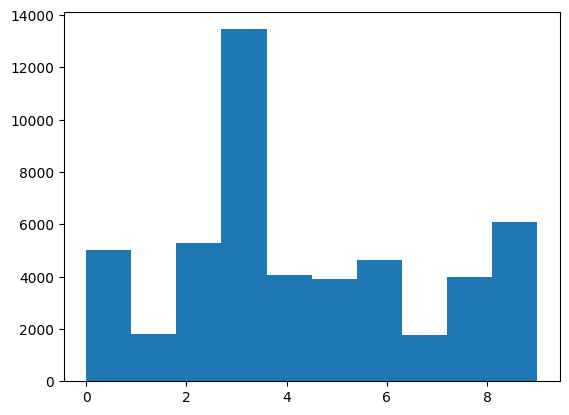

In [22]:
plt.hist(pred_naked)

(array([2985., 5571., 3461., 8238., 3593., 2947., 8787., 1759., 7008.,
        5651.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

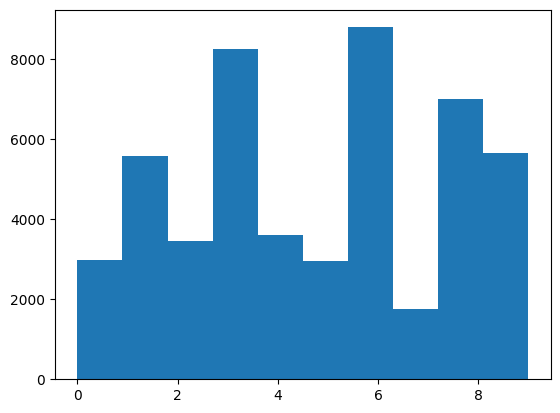

In [23]:
plt.hist(pred_protected)